#  Imports

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

from tensorflow.keras import Model
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Preprocesado


In [3]:
def load_and_rotate_image(file_path, image_size=224):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [image_size, image_size])
    k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    label = k
    image = tf.image.rot90(image, k=k)
    image = (image / 127.5) - 1.0
    return image, label



## Crear dataset

In [4]:
def create_rotnet_dataset(image_dir, image_size=224, batch_size=32):
    print(f"📁 Cargando imágenes desde: {image_dir}")

    image_paths = []
    for root, _, files in os.walk(image_dir):
        for fname in files:
            if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                image_paths.append(os.path.join(root, fname))
    print(f"🔢 Total de imágenes encontradas: {len(image_paths)}")
   

    dataset = tf.data.Dataset.from_tensor_slices(image_paths)

    # Mapear con la función de carga y rotación
    dataset = dataset.map(lambda path: load_and_rotate_image(path, image_size=image_size),
                          num_parallel_calls=tf.data.AUTOTUNE)

    #normalizar las imágenes
    def normalize_image(image, label=None):
        image = tf.cast(image, tf.float32) / 255.0  # Normalizar a [0, 1]
        return image, label
    dataset = dataset.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
    # Barajar, agrupar en lotes y prefetch
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)


    print(f"⏱️ Preprocesamiento completado.\n")

    return dataset


In [5]:
image_dir = "e:/TFM/DB/pocRotnet"
image_dir="e:/TFM/PlantsClassification/train"
# image_dir = os.path.join(execution_path,  "pocRotnet")
train = create_rotnet_dataset("e:/TFM/PlantsClassification/train")
test= create_rotnet_dataset("e:/TFM/PlantsClassification/test")
val= create_rotnet_dataset("e:/TFM/PlantsClassification/val")

📁 Cargando imágenes desde: e:/TFM/PlantsClassification/train
🔢 Total de imágenes encontradas: 20300
⏱️ Preprocesamiento completado.

📁 Cargando imágenes desde: e:/TFM/PlantsClassification/test
🔢 Total de imágenes encontradas: 5800
⏱️ Preprocesamiento completado.

📁 Cargando imágenes desde: e:/TFM/PlantsClassification/val
🔢 Total de imágenes encontradas: 2900
⏱️ Preprocesamiento completado.



##  Definir modelo

In [6]:
model = base_model = tf.keras.applications.ResNet50(weights=None, include_top=False, input_shape=(224, 224, 3))

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(4, activation="softmax")  # 4 clases: 0, 90, 180, 270 grados
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                                 
Total params: 23,595,908
Trainable params: 23,542,788
Non-trainable params: 53,120
_________________________________________________________________


## Ejecutar entrenamiento

In [7]:
# model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
print("🚀 Comenzando el entrenamiento...\n")

for batch in train.take(1):
    x, y = batch
    print("🧪 x shape:", x.shape)
    print("🧪 y shape:", y.shape)
    print("🧪 y dtype:", y.dtype)
    print("🧪 y example:", y[0])
# history = model.fit(dataset, epochs=100, verbose=2)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5 , restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath='best_modelV5.h5', save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', verbose=1, factor=0.2, min_lr=1e-6),
]

history = model.fit(
    train,
    validation_data=test,
    epochs=50,
    callbacks=callbacks,
    verbose=1

)



print(f"\n✅ Entrenamiento finalizado.")

save_path = "E:/TFM/rotnet_model3.keras"
model.save(save_path)
print(f"💾 Modelo guardado en: {save_path}")


🚀 Comenzando el entrenamiento...

🧪 x shape: (32, 224, 224, 3)
🧪 y shape: (32,)
🧪 y dtype: <dtype: 'int32'>
🧪 y example: tf.Tensor(1, shape=(), dtype=int32)
Epoch 1/50
 72/635 [==>...........................] - ETA: 2:12 - loss: 1.5586 - accuracy: 0.2843

KeyboardInterrupt: 

## Visualizar

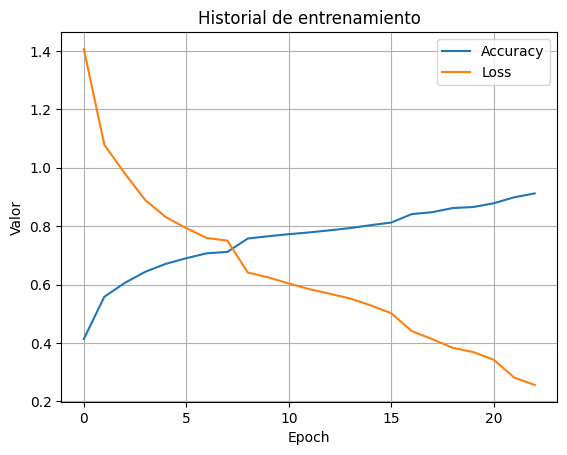

In [ ]:
import matplotlib.pyplot as plt
def plot_training_history(history):
    plt.figure(figsize=(12, 12))
    
    # Pérdida
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss during Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('accuracy during Training')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()


# Llamar a la función para graficar el progreso del entrenamiento
plot_training_history(history)


1/1 [==============================] - 1s 637ms/step


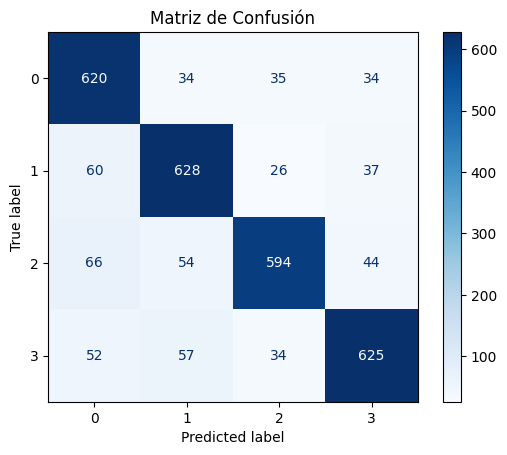

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Obtener predicciones y etiquetas verdaderas
y_true = []
y_pred = []

for images, labels in val:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(4))  # Ajusta el rango según tus clases
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()

In [60]:
import pickle

history_path = "E:/TFM/history3.pkl"
with open(history_path, "wb") as f:
    pickle.dump(history.history, f)

print(f"💾 Historial guardado en: {history_path}")


💾 Historial guardado en: E:/TFM/history3.pkl


In [13]:
import tensorflow as tf
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
])
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory='E:/TFM/PlantsClassification/train',
    labels='inferred',
    label_mode='int',         # entero para usar sparse_categorical_crossentropy
    batch_size=64,
    image_size=(224, 224),    # ajusta si usas otra entrada en tu modelo
    shuffle=True,
    seed=42
)
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory='E:/TFM/PlantsClassification/test',
    labels='inferred',
    label_mode='int',         # entero para usar sparse_categorical_crossentropy
    batch_size=64,
    image_size=(224, 224),    # ajusta si usas otra entrada en tu modelo
    shuffle=True,
    seed=42
)
val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory='E:/TFM/PlantsClassification/val',
    labels='inferred',
    label_mode='int',         # entero para usar sparse_categorical_crossentropy
    batch_size=64,
    image_size=(224, 224),    # ajusta si usas otra entrada en tu modelo
    shuffle=True,
    seed=42
)

Found 21000 files belonging to 30 classes.
Found 6000 files belonging to 30 classes.
Found 3000 files belonging to 30 classes.


In [62]:



# Aplicamos la función


In [14]:
model = tf.keras.models.load_model("E:/TFM/rotnet_model3.keras")

rotnet_model= model
encoder = Model(
    inputs=rotnet_model.input,
    outputs=rotnet_model.layers[-2].output  # penúltima capa (antes de Dense(4))
)
for layer in encoder.layers:
    layer.trainable = False  # o True si vas a hacer fine-tuning
plant_model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(30, activation='softmax')
])
plant_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_5 (Dropout)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 512)               524800    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 256)              

In [64]:
# # encoder=rotnet_model=model = base_model = tf.keras.applications.MobileNetV2(weights="imagenet",include_top=True, input_shape=(224, 224, 3))
# # encoder.trainable = False  # Congelar el modelo base
# rotnet_model= model
# encoder = Model(
#     inputs=rotnet_model.input,
#     outputs=rotnet_model.layers[-2].output  # penúltima capa (antes de Dense(4))
# )
# for layer in encoder.layers:
#     layer.trainable = False  # o True si vas a hacer fine-tuning
# plant_model = tf.keras.Sequential([
#     encoder,
#     tf.keras.layers.Flatten(),  # or GlobalAveragePooling2D() if Flatten hasn't been applied earlier
#     tf.keras.layers.Dense(512, activation="relu"),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.4),
#     tf.keras.layers.Dense(256, activation="relu"),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.4),
#     tf.keras.layers.Dense(128, activation="relu"),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.4),
#     tf.keras.layers.Dense(64, activation="relu"),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.4),
#     tf.keras.layers.Dense(30, activation="softmax")
# ])
# plant_model.summary()

In [16]:
plant_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

history2=plant_model.fit(
    train_dataset,  # tus datos con 30 clases verdaderas
    validation_data=test_dataset,
    verbose=1,
    epochs=50,
    batch_size=64,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",  # Monitorear la pérdida en los datos de validación
            patience=5,  # Aumentar la paciencia para permitir más iteraciones
            restore_best_weights=True,  # Restaurar los mejores pesos al final
            min_delta=1e-3,  # Mínima mejora requerida para considerar un cambio significativo
            verbose=1  # Mostrar mensajes cuando se active el EarlyStopping
        )
        
    ]
)
save_path = "E:/TFM/plant_model_full3.keras"
plant_model.save(save_path)
print(f"💾 Modelo guardado en: {save_path}")


Epoch 1/50
329/329 [==============================] - 58s 165ms/step - loss: 3.4120 - accuracy: 0.0297 - val_loss: 3.4013 - val_accuracy: 0.0333
Epoch 2/50
329/329 [==============================] - 53s 161ms/step - loss: 3.4015 - accuracy: 0.0305 - val_loss: 3.4012 - val_accuracy: 0.0333
Epoch 3/50
329/329 [==============================] - 52s 159ms/step - loss: 3.4015 - accuracy: 0.0296 - val_loss: 3.4012 - val_accuracy: 0.0333
Epoch 4/50
329/329 [==============================] - 53s 160ms/step - loss: 3.4015 - accuracy: 0.0310 - val_loss: 3.4012 - val_accuracy: 0.0333
Epoch 5/50
329/329 [==============================] - 53s 159ms/step - loss: 3.4015 - accuracy: 0.0295 - val_loss: 3.4012 - val_accuracy: 0.0333
Epoch 6/50
329/329 [==============================] - 53s 159ms/step - loss: 3.4017 - accuracy: 0.0297 - val_loss: 3.4012 - val_accuracy: 0.0333
Epoch 6: early stopping
💾 Modelo guardado en: E:/TFM/plant_model_full3.keras


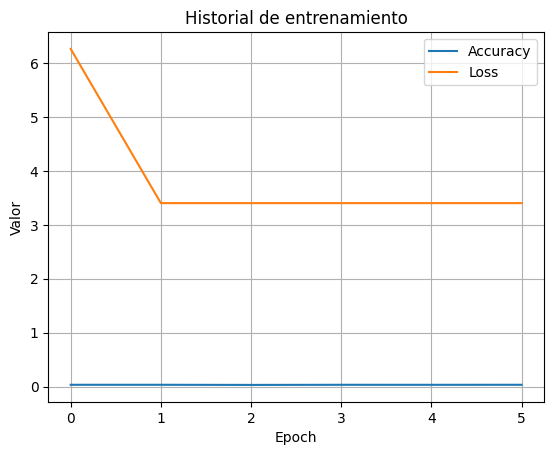

In [66]:
plt.plot(history2.history["accuracy"], label="Accuracy")
plt.plot(history2.history["loss"], label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Valor")
plt.title("Historial de entrenamiento")
plt.legend()
plt.grid()
plt.show()

2/2 [==============================] - 1s 190ms/step


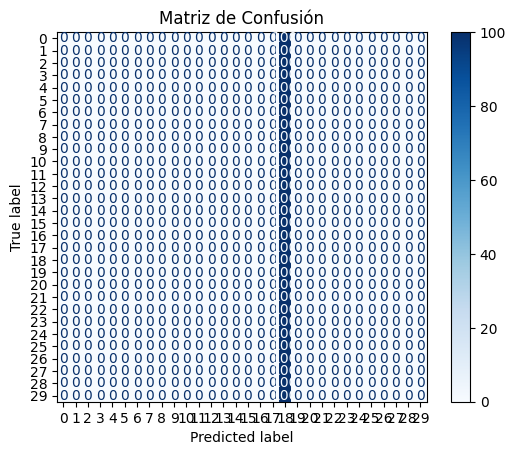

In [67]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Obtener predicciones y etiquetas verdaderas
y_true = []
y_pred = []

for images, labels in val_dataset:
    predictions = plant_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(30))  # Ajusta el rango según tus clases
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()